In [17]:
!python3 -m pip install powerlaw

In [18]:
import igraph as ig
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import islice
from tqdm import tqdm
import os
from random import sample
import scipy.stats as stats
import powerlaw

In [3]:
## Matplotlib defaults ##
colors = {"1980": "#aa0f35", 
         "1985": "#fdc799",
         "1990": "#abdbfc",
         "1995": "#a0a75c",
         "2000": "#603734",
         "2005": "#009ecb",
         "2010": "#430057",
         "2015": "#f89b00"}

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rcParams.update({'font.size': 22})

# Degree Analysis

Compare degree distributions & other degree-based stats

## Degree distributions

Comparisons of degree distributions across months

In [12]:
#TESTING - get one month working
cpd_degrees = pickle.load(file=open("Data/Degrees/cpd_degrees_1980-01.p", "rb"))
patent_degrees = pickle.load(file=open("Data/Degrees/patent_degrees_1980-01.p", "rb"))

print(type(cpd_degrees))
print(cpd_degrees[0:10])

<class 'list'>
[1, 84, 5, 2, 1, 14, 6, 1, 55, 4]


In [14]:
#Bastic stats
print(stats.describe(cpd_degrees))
print()
print(stats.describe(patent_degrees))

DescribeResult(nobs=551235, minmax=(1, 596829), mean=289.3535007755313, variance=22220054.09029946, skewness=51.599033457631066, kurtosis=3940.7540822292654)

DescribeResult(nobs=4578946, minmax=(0, 5020), mean=34.833731823873876, variance=4045.377753074271, skewness=7.511152075165203, kurtosis=165.978253118909)


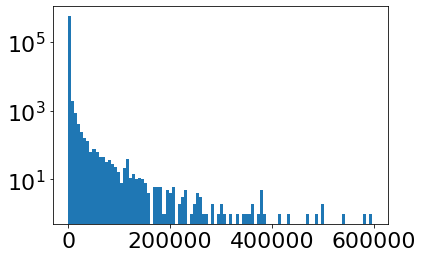

In [11]:
plt.hist(cpd_degrees, bins=100)
plt.yscale("log")

plt.show()

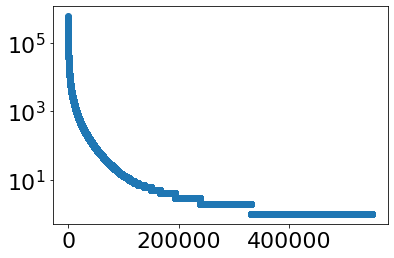

In [36]:
cpd_degrees.sort(reverse=True)

plt.scatter(np.arange(0,len(cpd_degrees),1), cpd_degrees)
plt.yscale("log")

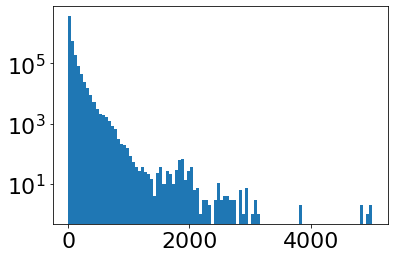

In [15]:
plt.hist(patent_degrees, bins=100)
plt.yscale("log")

plt.show()

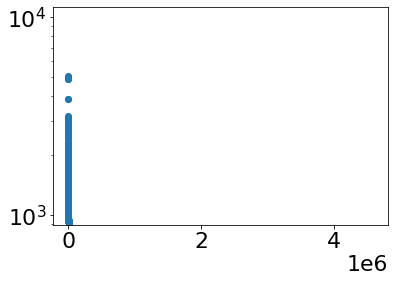

In [37]:
patent_degrees.sort(reverse=True)

plt.scatter(np.arange(0,len(patent_degrees),1), patent_degrees)
plt.yscale("log")

### Powerlaw Testing

In [25]:
#Powerlaw testing
fit = powerlaw.Fit(cpd_degrees)
print(fit)

Calculating best minimal value for power law fit
/usr/local/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


In [32]:
print(fit.power_law.alpha)
print(fit.power_law.sigma)
print(fit.power_law.xmin)

#NOTE: positive R = first fit is better. Negative R = second fit is better. p is the significance in either case.
R, p = fit.distribution_compare('power_law', 'exponential')
print(R, p)
R, p = fit.distribution_compare('power_law', 'lognormal')
print(R, p)

2.113126061345115
0.022566972331619188
11845.0
431.3385623929011 2.3925672195144096e-21
-29.32081248237728 5.435056912214664e-07


<AxesSubplot:>

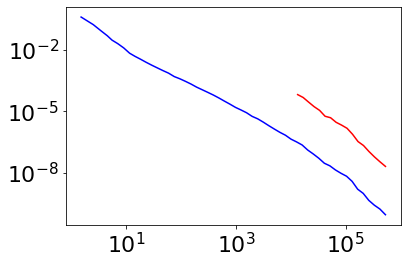

In [30]:
powerlaw.plot_pdf(cpd_degrees, color='b')
fit.plot_pdf(color='r')

# Network Statistics

Nodes, Edges, cpds vs patents, avg degree, max degree, etc...

In [39]:
df = pd.read_csv("Data/NetworkStats/stats_cpdsPatents_1980-01.csv")
print(df)

   Unnamed: 0    Nodes      Edges  Cpd Nodes  Patent Nodes  Avg Degree  \
0           0  5130181  159501777     551235       4578946   62.181735   

   Cpd Avg Degree  Patent Avg Degree  LCC Size  
0      289.353501          34.833732   5035294  


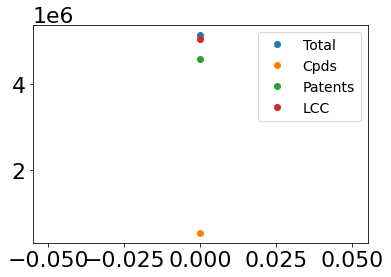

In [51]:
#Plot all sizes on one plot
plt.plot(df["Nodes"], 'o', label="Total", )
plt.plot(df["Cpd Nodes"], 'o', label="Cpds")
plt.plot(df["Patent Nodes"], 'o', label="Patents")
plt.plot(df["LCC Size"], 'o', label="LCC")

plt.legend(prop={"size":14})

## LCC Analysis

Which IDs are present, do they change over time, etc...

In [52]:
lcc_ids = pickle.load(file=open("Data/NetworkStats/lcc_ids_1980-01.p", "rb"))
print(type(lcc_ids))

<class 'list'>


In [62]:
print(type(lcc_ids[0]))
print(len(lcc_ids[0]))
print(lcc_ids[0][0])

<class 'list'>
5035294
SCHEMBL41
